<a href="https://colab.research.google.com/github/mamuncseru/x-ray-cnn/blob/main/Medical_X_ray.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

# 1 The Dataset
The dataset that we are going to use for the image classification is Chest X-Ray images, which consists of 2 categories, Pneumonia and Normal. This dataset was published by Paulo Breviglieri, a revised version of Paul Mooney's most popular dataset. This updated version of the dataset has a more balanced distribution of the images in the validation set and the testing set. The data set is organised into 3 folders (train, test, val) and contains subfolders for each image category Opacity(viz. Pneumonia) & Normal.

\
*Total number of observations (images): 5,856
Training observations: 4,192 (1,082 normal cases, 3,110 lung opacity cases)
Validation observations: 1,040 (267 normal cases, 773 lung opacity cases)
Testing observations: 624 (234 normal cases, 390 lung opacity cases)*

In [ ]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

In [ ]:
import zipfile
zf = "/content/chest-xray-pneumonia.zip"
target_dir = "/content/drive/MyDrive/X-ray-dataset"
zfile = zipfile.ZipFile(zf)
zfile.extractall(target_dir)

# 2 Initialize
In this part of the code, we will define the directory path, import some needed libraries, and define some common constant parameters that we will often use in later parts of the project.

In [2]:
#Some Basic Imports
import matplotlib.pyplot as plt #For Visualization
import numpy as np              #For handling arrays
import pandas as pd             # For handling data
#Define Directories for train, test & Validation Set
train_path = '/content/drive/MyDrive/X-ray-dataset/chest_xray/train'
test_path = '/content/drive/MyDrive/X-ray-dataset/chest_xray/test'
valid_path = '/content/drive/MyDrive/X-ray-dataset/chest_xray/val'
#Define some often used standard parameters
#The batch refers to the number of training examples utilized in one #iteration
batch_size = 16 
#The dimension of the images we are going to define is 500x500 
img_height = 500
img_width = 500

# 3 Preparing the Data
### 3.1 Data Augmentation

We will increase the size of the image training dataset artificially by performing some Image Augmentation technique.

*Image Augmentation expands the size of the dataset by creating a modified version of the existing training set images that helps to increase dataset variation and ultimately improve the ability of the model to predict new images.*

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Create Image Data Generator for Train Set
image_gen = ImageDataGenerator(
                                  rescale = 1./255,
                                  shear_range = 0.2,
                                  zoom_range = 0.2,
                                  horizontal_flip = True,          
                               )
# Create Image Data Generator for Test/Validation Set
test_data_gen = ImageDataGenerator(rescale = 1./255)

Using the `tensorflow.keras.preprocessing.image` library, for the Train Set, we created an Image Data Generator that randomly applies defined parameters to the train set and for the Test & Validation set, we’re just going to rescale them to avoid manipulating the test data beforehand.

#### Defining some of the Image Data Generator parameters:-

- rescale —Each digital image is created by a pixel with a value between 0 and 255. 0 in black, 255 in white. So rescale the scales array of the original image pixel values to be between [0,1] which makes the images contribute more equally to the overall loss. Otherwise, higher pixel range image results in greater loss and a lower learning rate should be used, lower pixel range image would require a higher learning rate.

- shear_range — The shape of the image is the transformation of the shear. It fixes one axis and stretches the image at a certain angle known as the angle of the shear.

- zoom_range — The image is enlarged by a zoom of less than 1.0. The image is more than 1.0 zoomed out of the picture.

- horizontal_flip —Some images are flipped horizontally at random

- vertical_flip — Some images are flipped vertically at random
- roataion_range — Randomly, the image is rotated by some degree in the range 0 to 180.

- width_shift_range — Shifts the image horizontally.

- height_shift_range — Shifts the image vertically.

- brightness_range — brightness of 0.0 corresponds to absolutely no brightness, and 1.0 corresponds to maximum brightness

- fill_mode — Fills the missing value of the image to the nearest value or to the wrapped value or to the reflecting value.

- These transformation techniques are applied randomly to the images, except for the rescale. All images have been rescaled.

### 3.2 Loading the Images
The Image Data Generator has a class known as flow from directory to read the images from folders containing images. Returns the DirectoryIterator `typetensorflow.python.keras.preprocessing.image.DirectoryIterator`.

In [4]:
train = image_gen.flow_from_directory(
      train_path,
      target_size=(img_height, img_width),
      color_mode='grayscale',
      class_mode='binary',
      batch_size=batch_size
      )
test = test_data_gen.flow_from_directory(
      test_path,
      target_size=(img_height, img_width),
      color_mode='grayscale',
      shuffle=False, 
#setting shuffle as False just so we can later compare it with predicted values without having indexing problem 
      class_mode='binary',
      batch_size=batch_size
      )
valid = test_data_gen.flow_from_directory(
      valid_path,
      target_size=(img_height, img_width),
      color_mode='grayscale',
      class_mode='binary', 
      batch_size=batch_size
      )

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


#### Some of the parameters it takes in are defined below :-

- directory — The first parameter used is the path of the train, test & validation folder that we defined earlier.

- target_size — The target size is the size of your input images, each image will be resized to this size. We have defined the target size earlier as 500 x 500.

- color_mode —If the image is either black and white or grayscale set to “grayscale” or if the image has three colour channels set to “rgb.” We’re going to work with the grayscale, because it’s the X-Ray images.

- batch_size — Number of images to be generated by batch from the generator. We defined the batch size as 16 earlier. We choose 16 because the size of the images is too large to handle the RAM.

- class_mode — Set “binary” if you only have two classes to predict, if you are not set to “categorical,” if you develop an Autoencoder system, both input and output are likely to be the same image, set to “input” in this case. Here we’re going to set it to binary because we’ve only got 2 classes to predict.

#### Let’s take a look at some of the train set images that we obtained from the Data Augmentation


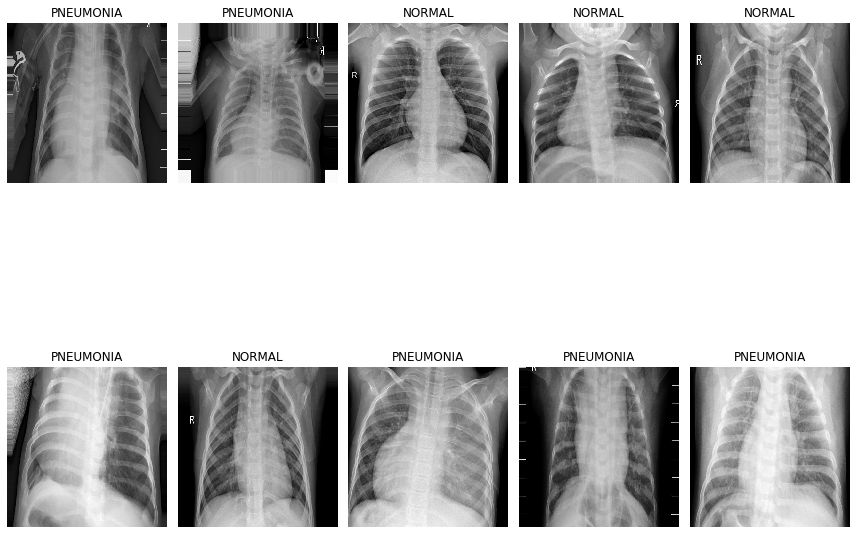

In [5]:
plt.figure(figsize=(12, 12))
for i in range(0, 10):
    plt.subplot(2, 5, i+1)
    for X_batch, Y_batch in train:
        image = X_batch[0]        
        dic = {0:'NORMAL', 1:'PNEUMONIA'}
        plt.title(dic.get(Y_batch[0]))
        plt.axis('off')
        plt.imshow(np.squeeze(image),cmap='gray',interpolation='nearest')
        break
plt.tight_layout()
plt.show()

# 4 Convolutional Neural Network
Tell me what is CNN in one sentence — `It an artificial neural network that has the ability to pin point or detect patterns in the images.`

**Explain what’s going on inside a CNN architecture** — 
CNN CNN architecture is based on layers of convolution. The convolution layers receive input and transform the data from the image and pass it as input to the next layer. The transformation is known as the operation of convolution. We need to define the number of filters for each convolution layer. These filters detect patterns such as edges, shapes, curves, objects, textures, or even colors. The more sophisticated patterns or objects it detects are more deeply layered. In essence, filters are image kernels that we can define as 3x3 or 4x4, which is a small matrix applied to an image as a whole. We will use Pooling layer together with Convolution layer as well as the goal is to down-sample an input representation (image), decrease its dimensionality by retaining the maximum value (activated features) in the sub regions binding. The number of pixels moving across the input matrix is called Stride. When the stride is 1 we move the filter to 1 pixel at a time. When the stride is 2 then we move the filter to 2 pixels at a time, and so on. Larger filter sizes and strides may be used to reduce the size of a large image to a moderate size.

\
Okay, if you hate math, all these complex mathematical operations are performed behind the scenes, all we need to do is define hyper parameters and layers. You can refer to the links in the reference section if you love math and want to see how these mathemagicical operations work.
There is great video on YT in which they try to create human neural network.


#### Lock and load as we start creating the CNN architecture.
### 4.1 Necessary imports



In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

### 4.2 CNN Architecture

Things to note before starting to build a CNN model:-

- Always begin with a lower filter value such as 32 and begin to increase it layer wise.

- Construct the model with a layer of Conv2D followed by a layer of MaxPooling.
- The kernel_size is preferred to be odd number like 3x3.
- Tanh, relu, etc. can be used for activation function, but relu is the most preferred activation function.
- input_shape takes in image width & height with last dimension as color channel.
- Flattening the input after CNN layers and adding ANN layers.

- Use activation function as softmax for the last layer If the problem is more than 2 classes, define units as the total number of classes and use sigmoid for binary classification and set unit to 1.

Note :- You can always experiment with these hyperparameters as there is no fixed value on which we can settle.

In [7]:
cnn = Sequential()
cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(64, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(64, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Flatten())
cnn.add(Dense(activation = 'relu', units = 128))
cnn.add(Dense(activation = 'relu', units = 64))
cnn.add(Dense(activation = 'sigmoid', units = 1))
cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [8]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 498, 498, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 249, 249, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 247, 247, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 123, 123, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 121, 121, 32)      9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 60, 60, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 58, 58, 64)        1

### Interpreting Model Summary
- Now we’ve developed the CNN model, let’s see in depth what’s going on here.
- Hyperparameters of Conv2D

`Conv2D(
    filters,
    kernel_size,
    strides=(1, 1),
    padding="valid",
    activation=None,
    input_shape=(height,width,color, channel)
    )`
- Hyperparameters of MaxPooling2D 

`MaxPooling2D(
    pool_size=(2, 2), strides=None, padding="valid"
    )`

#### Defining Model Compile
- Learning Rate — while training the aim for stochastic gradient descent is to minimize loss among actual and predicted values of training set. Path to minimize loss takes several steps. Adam is an adaptive learning rate method, which means, it computes individual learning rates for different parameters.

- loss function — Since it is a binary classification, we will use binary crossentropy during training for evaluation of losses. We would have gone for categorical crossentropy if there were more than 4 classes.

- metrics — accuracy — Calculate how often actual labels are equal to predictions. It will measure the loss and accuracy of training and validation.
### Visualize CNN model

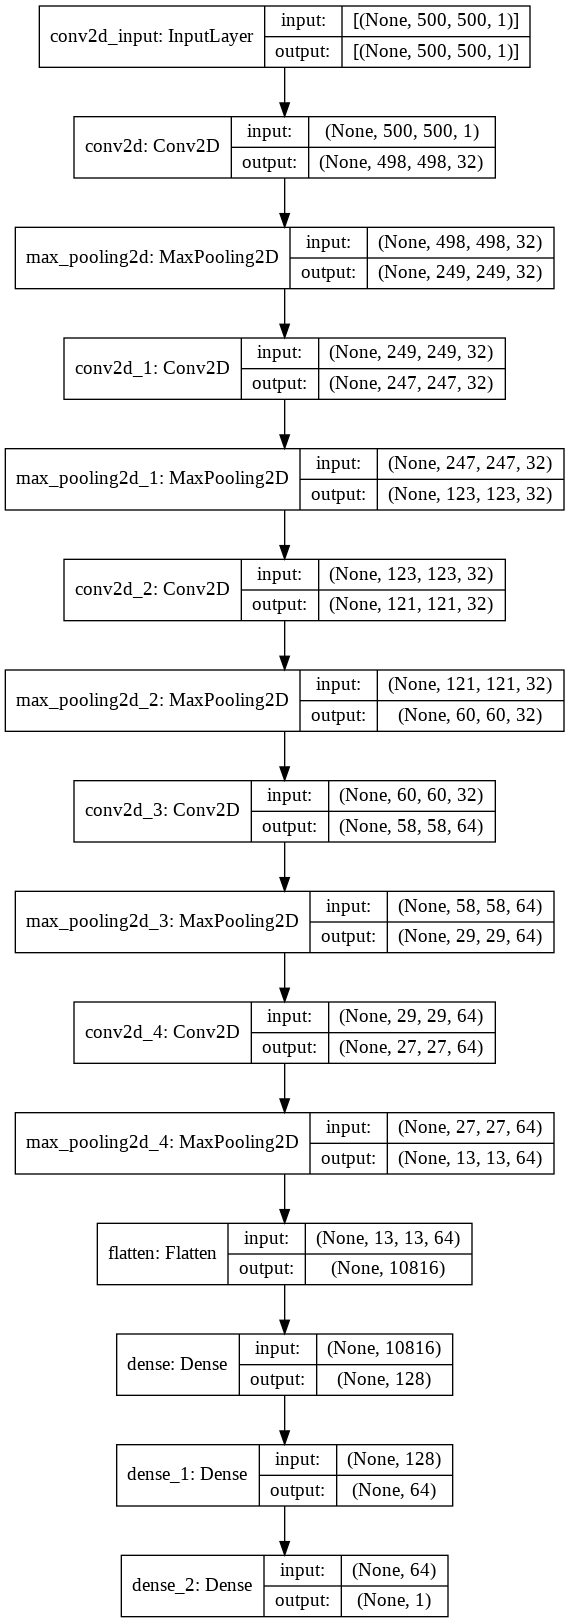

In [9]:
from tensorflow.keras.utils import plot_model
plot_model(cnn,show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True)

### 4.3 Fit the model
##### Defining Callback list
- EarlyStopping is called to stop the epochs based on some metric(monitor) and conditions (mode, patience) . It helps to avoid overfitting the model. Over here we are telling to stop based on val_loss metric, we need it to be minimum. patience says that after a minimum val_loss is achieved then after that in next iterations if the val_loss increases in any the 3 iterations then the the training will stop at that epoch.
- Reduce learning rate when a metric has stopped improving. Models often benefit from reducing the learning rate by a factor of 2–10 once learning stagnates. This callback monitors a quantity and if no improvement is seen for a ‘patience’ number of epochs, the learning rate is reduced. source

In [10]:
early = EarlyStopping(monitor="val_loss", mode="min", patience=3)
learning_rate_reduction = ReduceLROnPlateau(monitor="val_loss", patience = 2, verbose=1,factor=0.3, min_lr=0.000001)
callbacks_list = [ early, learning_rate_reduction]

### Assigning Class Weights
It is good practice to assign class weights for each class. It emphasizes the weight of the minority class in order for the model to learn from all classes equally.

In [11]:
from sklearn.utils.class_weight import compute_class_weight
weights = compute_class_weight('balanced', np.unique(train.classes), train.classes)
cw = dict(zip( np.unique(train.classes), weights))
print(cw)

{0: 1.9448173005219984, 1: 0.6730322580645162}


#### Now that everything is setup, moving on to final step TRAINING 💪

The parameters we are passing to model.fit are train set, epochs as 25, validation set used to calculate val_loss and val_accuracy, class weights and callback list.


In [12]:
cnn.fit(train,epochs=25, validation_data=valid, class_weight=cw, callbacks=callbacks_list)

Epoch 1/25
326/326 [==============================] - 3447s 10s/step - loss: 0.4083 - accuracy: 0.7770 - val_loss: 0.6545 - val_accuracy: 0.6250
Epoch 2/25
326/326 [==============================] - 169s 517ms/step - loss: 0.2451 - accuracy: 0.8965 - val_loss: 0.7062 - val_accuracy: 0.7500
Epoch 3/25
326/326 [==============================] - 166s 508ms/step - loss: 0.2172 - accuracy: 0.9080 - val_loss: 0.4144 - val_accuracy: 0.8125
Epoch 4/25
326/326 [==============================] - 166s 508ms/step - loss: 0.1947 - accuracy: 0.9183 - val_loss: 0.4534 - val_accuracy: 0.8125
Epoch 5/25
326/326 [==============================] - 165s 504ms/step - loss: 0.1786 - accuracy: 0.9252 - val_loss: 0.6281 - val_accuracy: 0.7500

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 6/25
326/326 [==============================] - 167s 511ms/step - loss: 0.1571 - accuracy: 0.9360 - val_loss: 0.4484 - val_accuracy: 0.7500


# 5 Evaluate
Let’s visualize the progress of all metrics throughout the total epochs lifetime


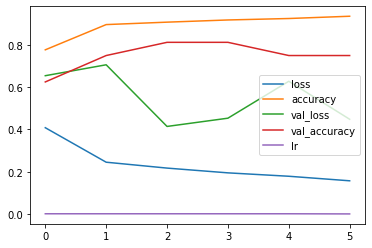

In [13]:
pd.DataFrame(cnn.history.history).plot()

In [14]:
# The accuracy we are getting on Test dataset is of 91%
test_accu = cnn.evaluate(test)
print('The testing accuracy is :',test_accu[1]*100, '%')

39/39 [==============================] - 387s 10s/step - loss: 0.2287 - accuracy: 0.9071
The testing accuracy is : 90.70512652397156 %


Let’s predict the test dataset and look at some of the performance measurement metrics in detail to evaluate our model.

In [15]:
preds = cnn.predict(test,verbose=1)

39/39 [==============================] - 7s 170ms/step


Since the activation function of the last layer is sigmoid, the model gives prediction in the 0 to 1 range and not an exact classification as 0 or 1. So we categorise all the values in the 0.5 to 1 range as 0 and less than 0.5 as 1. Note(0 denotes a normal case and 1 denotes a case of pneumonia)


In [16]:
predictions = preds.copy()
predictions[predictions <= 0.5] = 0
predictions[predictions > 0.5] = 1

### Confusion Matrix
Let’s interpret the output of the confusion matrix. The upper left (TP) denotes the number of images correctly predicted as normal cases and the bottom right (TN) denotes the correctly predicted number of images as cases of pneumonia. As Pneumonia case, the upper right denotes the number of incorrectly predicted images but were actually normal cases and the lower left denotes the number of incorrectly predicted Normal case images but were actually Pneumonia case.

### ?? Still Confused with Confusion matrix ??
The easy way to interpret the confusion matrix for binary or multiclass classification is to see if we get maximum values in diagonal cells from left to right and minimum value in the rest of the cells.

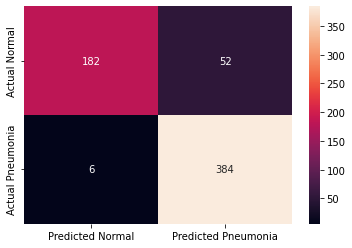

In [17]:
from sklearn.metrics import classification_report,confusion_matrix
cm = pd.DataFrame(data=confusion_matrix(test.classes, predictions, labels=[0, 1]),index=["Actual Normal", "Actual Pneumonia"],
columns=["Predicted Normal", "Predicted Pneumonia"])
import seaborn as sns
sns.heatmap(cm,annot=True,fmt="d")

### Classification Report
- Precision = TruePositives / (TruePositives + FalsePositives)
- Recall = TruePositives / (TruePositives + FalseNegatives)
- F1 = (2 * Precision * Recall) / (Precision + Recall)

In [18]:
print(classification_report(y_true=test.classes,y_pred=predictions,target_names =['NORMAL','PNEUMONIA']))

              precision    recall  f1-score   support

      NORMAL       0.97      0.78      0.86       234
   PNEUMONIA       0.88      0.98      0.93       390

    accuracy                           0.91       624
   macro avg       0.92      0.88      0.90       624
weighted avg       0.91      0.91      0.90       624



Let’s visualize some of the predicted images with percentage %


(624, 500, 500, 1)
(624,)


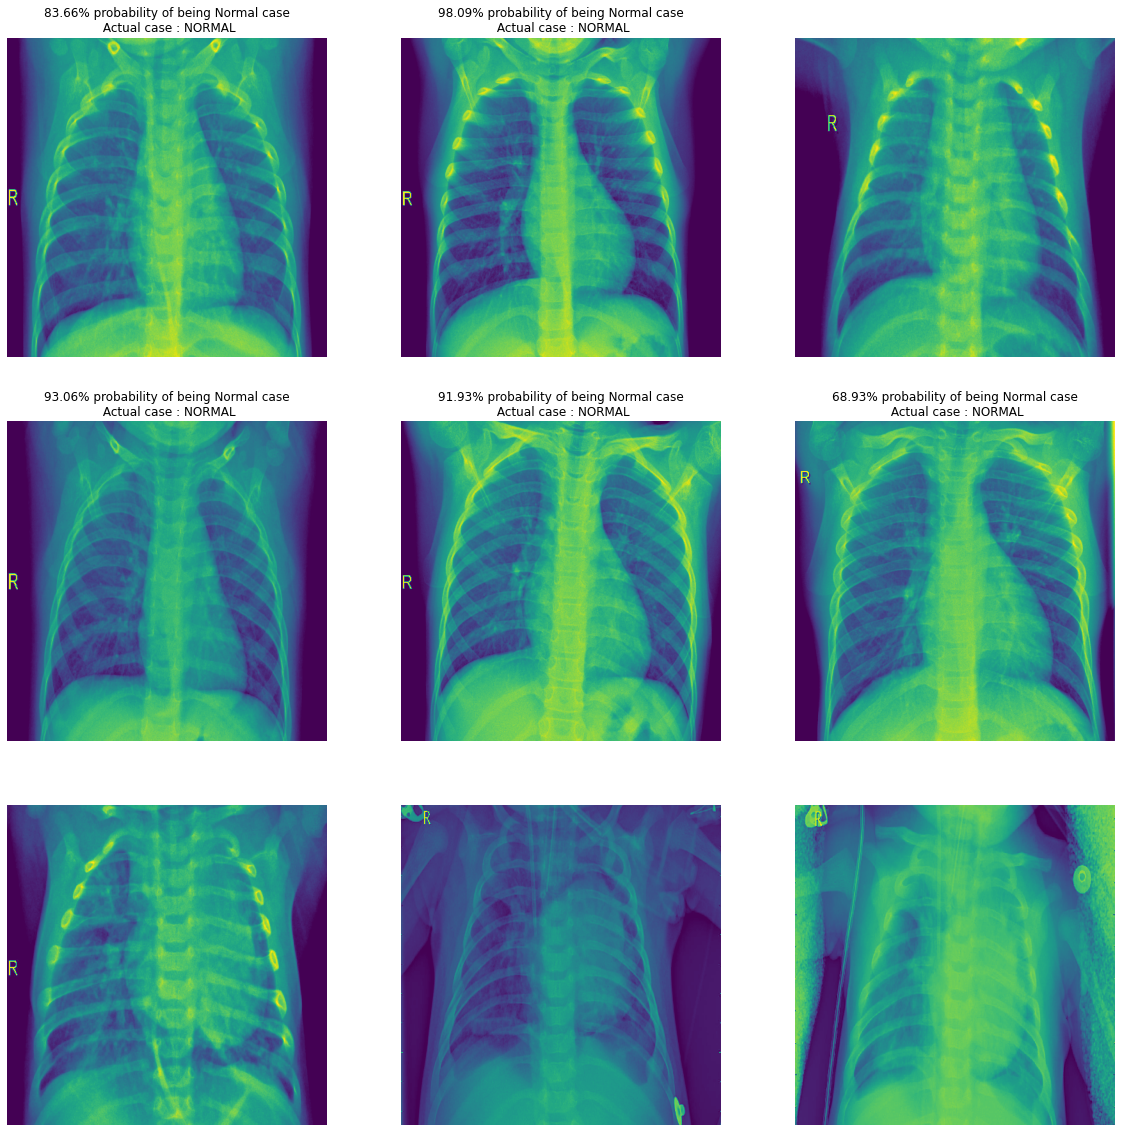

In [20]:
test.reset()
x=np.concatenate([test.next()[0] for i in range(test.__len__())])
y=np.concatenate([test.next()[1] for i in range(test.__len__())])
print(x.shape)
print(y.shape)
#this little code above extracts the images from test Data iterator without shuffling the sequence
# x contains image array and y has labels 
dic = {0:'NORMAL', 1:'PNEUMONIA'}
plt.figure(figsize=(20,20))
for i in range(0+228, 9+228):
  plt.subplot(3, 3, (i-228)+1)
  if preds[i, 0] >= 0.5: 
      out = ('{:.2%} probability of being Pneumonia case'.format(preds[i][0]))
      
      
  else: 
      out = ('{:.2%} probability of being Normal case'.format(1-preds[i][0]))
      plt.title(out+"\n Actual case : "+ dic.get(y[i]))    
  plt.imshow(np.squeeze(x[i]))
  plt.axis('off')
plt.show()

This code block gives a percentage prediction of the individual image that can be loaded directly from your drive by specifying its path.
We have to re-create all the data preprocessing steps over here after importing the image as we had done previously to feed the test set into the model to get prediction. For pre-processing we need to import tensorflow.keras.preprocessing.image class.
- Import image and define dimensions as (500,500) and color channel as grayscale.
- Convert image to array, rescale it by dividing it 255 and expand dimension by axis = 0 as our model takes 4 dimensions as seen earlier.
- Finally let’s predict the case!
Let’s do some field testing on our model with my X-ray

In [ ]:
# Testing with my own Chest X-Ray
hardik_path = '/content/drive/My Drive/unsegregated /IMG_20201023_204205928~2.jpg'
from tensorflow.keras.preprocessing import image
hardik_img = image.load_img(hardik_path, target_size=(500, 500),color_mode='grayscale')
# Preprocessing the image
pp_hardik_img = image.img_to_array(hardik_img)
pp_hardik_img = pp_hardik_img/255
pp_hardik_img = np.expand_dims(pp_hardik_img, axis=0)
#predict
hardik_preds= cnn.predict(pp_hardik_img)
#print
plt.figure(figsize=(6,6))
plt.axis('off')
if hardik_preds>= 0.5: 
    out = ('I am {:.2%} percent confirmed that this is a Pneumonia case'.format(hardik_preds[0][0]))
    
else: 
    out = ('I am {:.2%} percent confirmed that this is a Normal case'.format(1-hardik_preds[0][0]))
plt.title("Hardik's Chest X-Ray\n"+out)  
plt.imshow(np.squeeze(pp_hardik_img))
plt.show()